# Use kernel 'second' to execute this file
# Import necessary libraries.

In [2]:
import spacy
import textacy
#import textacy.preprocessing
import textacy.resources
#import textacy.keyterms
#import textacy.ke
#import neuralcoref
from spacy.symbols import ORTH, POS, NOUN, VERB,PRON
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt 
import spacy
import textacy
from nltk import sent_tokenize, word_tokenize, pos_tag
nlp = spacy.load("en_core_web_sm")
from allennlp_models.pretrained import load_predictor
predictor1 = load_predictor("glove-sst")
import seaborn as sns
import pandas as pd
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('D:/github/causal-graph-acquisition/SentiStrengthCom.jar')
senti.setSentiStrengthLanguageFolderPath('D:/github/causal-graph-acquisition/SentStrength_Data_Sept2011/')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from afinn import Afinn
afn = Afinn()
from pd_replicator import replicator
from nltk.corpus import stopwords
set(stopwords.words('english'))

lerc is not a registered model.


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

# Read text file and preprocess.

In [3]:
file_name = './Text/Causal Sentences.txt'
narrative = open(file_name, encoding="utf8").read()
narrative = narrative.lower()

#print('\nNLTK Sentences:\n')
raw_sentences = sent_tokenize(str(narrative))
print(len(raw_sentences))
# for sent in raw_sentences:
#     print(sent)
#     print()

380


# Extract the Subject-Verb-Object triples.

In [4]:
finalList = []
sentences = []
ncl = []
nncl = [()]
checkPass = False
rootCheck = False
varForm1 = False
varForm2 = False
sub = ''
obj = ''
for sent in raw_sentences:
    sent = nlp(sent)
    #print("Sentence:")
    print(sent) 
    #print("Noun Chunks:")
    for nc in sent.noun_chunks:
        #print (nc)
        ncl.append(nc)
    #print ("Number of noun chunks: ", len(ncl)) 
    triplets = textacy.extract.subject_verb_object_triples(sent)
    triplets = list(triplets)
    if len(triplets) > 0:
        #print("Triples from textacy:")
        for t in triplets:
            subject = t[0]
            objec = t[2]
            for chunk in ncl:
                for cToken in chunk:
                    if str(cToken) == str(t[0]):
                        subject = chunk
                    if str(cToken) == str(t[2]):
                        objec = chunk
            tup = (subject,t[1],objec)
            print(tup)
            finalList.append(tup)
            sentences.append(sent)
        if len(ncl) == 3:
            nncl = [(ncl[0],triplets[0][1],ncl[1])]
            nncl.append((ncl[0],triplets[0][1],ncl[2]))
            #print("Triples other than textacy:")
            #print(nncl[0])
            #print(nncl[1])
            finalList.append(nncl[0])
            sentences.append(sent)
            finalList.append(nncl[1])
            sentences.append(sent)
    else:
        #print("Method from textacy; subject_verb_object_triples extracted nothing!")
        for token in sent:
            #print(token.text, token.dep_,)
            if token.dep_ == 'nsubj':
                sub = token
                #tuple[0] = str(token.text)
            elif token.dep_ == 'nsubjpass':
                checkPass = True
                sub = token
            elif token.dep_ == 'ROOT':
                #print("Heyyyyyyy")
                verb = token
                #print(verb)
                rootCheck = True
            elif token.pos_ == 'NOUN' and token.dep_ == 'conj':
                if rootCheck is True:
                    varForm2 = True
                else:
                    varForm1 = True
            else:
                if token.dep_ == 'dobj':
                    obj = token
                    continue
                elif token.dep_ == 'pobj':
                    obj = token
                    continue           
        for nChunk in ncl:
            for nToken in nChunk:
                if str(nToken) == str(sub):
                    sub = nChunk
                if str(nToken) == str(obj):
                    obj = nChunk
        if checkPass is True:
            tuple = (obj,verb,sub)
        else:
            tuple = (sub,verb,obj)
        #print("Triple by combining nsubj, root and dobj:")
        #print(tuple)
        finalList.append(tuple)
        sentences.append(sent)
        if len(ncl) == 3:
            if varForm1 == True:
                nncl = [(ncl[0],verb,ncl[2])]
                nncl.append((ncl[1],verb,ncl[2]))
                #print("Triples other than sub, verb and obj:")
                #print(nncl[0])
                #print(nncl[1])
                finalList.append(nncl[0])
                sentences.append(sent)
                finalList.append(nncl[1])
                sentences.append(sent)
            else:
                nncl = [(ncl[0],verb,ncl[1])]
                nncl.append((ncl[0],verb,ncl[2]))
                #print("Triples other than sub, verb and obj:")
                #print(nncl[0])
                #print(nncl[1])
                finalList.append(nncl[0])
                sentences.append(sent)
                finalList.append(nncl[1])
                sentences.append(sent)
    ncl.clear()
    nncl.clear()
    rootCheck = False
    checkPass = False
    varForm1 = False
    varForm2 = False
trips = finalList
print(trips)

the company modernized its technology.
(the company, modernized, its technology)
the singer released a single.
(the singer, released, a single)
the doctor saved a life.
(the doctor, saved, a life)
the farmer harvested the wheat.
(the farmer, harvested, the wheat)
the artist painted a landscape.
(the artist, painted, a landscape)
the dog chased its tail.
(the dog, chased, its tail)
the bird nested in the tree.
the teacher planned the lesson.
(the teacher, planned, the lesson)
the child played with friends.
the company invested in research.
the band recorded a demo.
(the band, recorded, a demo)
the doctor referred the patient.
(the doctor, referred, the patient)
the engineer tested the prototype.
(the engineer, tested, the prototype)
the scientist published a paper.
(the scientist, published, a paper)
the worker installed the software.
(the worker, installed, the software)
the author wrote a poem.
(the author, wrote, a poem)
the player scored a hat trick.
(the player, scored, hat trick)


# Remove Duplicates from Triples

In [5]:
print("Length of triples' List before removing duplicates:")
print(len(trips))

Triples = []
sentences1 = []

for sentence,ce in zip(sentences, trips):
    check = False
    #print("ce:")
    #print(ce)
    if len(Triples) == 0:
        #print("HEY!")
        Triples.append(ce)
        sentences1.append(sentence)
        #print("added!")
    else:
        for ct in Triples:
            #print("ct:")
            #print(ct)
            if str(ce[0]) == str(ct[0]) and str(ce[1]) == str(ct[1]) and str(ce[2]) == str(ct[2]):
                #print("duplicate")
                check = True
                break;
        if check == False:
            Triples.append(ce)
            sentences1.append(sentence)
            #print("added!")

print("\nList after removing duplicates:")
print(len(Triples))

#for t in Triples:
#    print(t)
    
#print(len(sentences1))

Length of triples' List before removing duplicates:
561

List after removing duplicates:
487


# Filter correct triples from extracted triples

In [6]:
causalTriples = []
causalSentences = []

for sentence,line in zip(sentences1, Triples):
    taggedWords = []
    taggedWords1 = []
    check0 = False
    check2 = False
    #print(line)
    taggedWords = pos_tag(word_tokenize(str(line[0])))
    taggedWords1 = pos_tag(word_tokenize(str(line[2])))
    #print(taggedWords)
    #print(taggedWords1)
    for i in range(len(taggedWords)):
        if taggedWords[i][1] == 'NN' or taggedWords[i][1] == 'NNS':
            check0 = True
    for i in range(len(taggedWords1)):
        if taggedWords1[i][1] == 'NN' or taggedWords1[i][1] == 'NNS':
            check2 = True
    #print(check0)  
    #print(check2)
    if check0 == True and check2 == True:
        causalTriples.append(line)
        causalSentences.append(sentence)
    #print("**************************************************************************")
    
#for correctTriple in causalTriples:
#    print(correctTriple)

print(len(causalTriples))

466


# Print the extracted triples with sentences and verbs

In [7]:
causalVerbs = []
for triple in causalTriples:
    causalVerbs.append(triple[1])

for sentence, triple, verb  in zip(causalSentences, causalTriples, causalVerbs):
    print(sentence, triple, verb)
    print()

the company modernized its technology. (the company, modernized, its technology) modernized

the doctor saved a life. (the doctor, saved, a life) saved

the farmer harvested the wheat. (the farmer, harvested, the wheat) harvested

the artist painted a landscape. (the artist, painted, a landscape) painted

the dog chased its tail. (the dog, chased, its tail) chased

the bird nested in the tree. (the bird, nested, the tree) nested

the teacher planned the lesson. (the teacher, planned, the lesson) planned

the child played with friends. (the child, played, friends) played

the company invested in research. (the company, invested, research) invested

the band recorded a demo. (the band, recorded, a demo) recorded

the doctor referred the patient. (the doctor, referred, the patient) referred

the engineer tested the prototype. (the engineer, tested, the prototype) tested

the scientist published a paper. (the scientist, published, a paper) published

the worker installed the software. (the

# Causal Triples' Polarity (Whole) 

### [AllenNlp] 

In [8]:
allen = []
for sent in causalTriples:
    #print(sent)
    preds = predictor1.predict(str(sent))
    #print(preds['label'][0])
    label = preds['label'][0]
    if label is '0':
        allen.append(-1)
    else:
        allen.append(1)
    
#for causalSentence, polarity  in zip(causalTriples, allen):
#    print(causalSentence, polarity)

### [Afinn]

In [9]:
afinn = []
for sent in causalTriples:
    #print(str(sent))
    score = afn.score(str(sent))
    #print(score)
    if score > 0:
        #print('positive')
        afinn.append(1)
    elif score < 0:
        #print('negative')
        afinn.append(-1)
    else:
        #print('neutral')
        afinn.append(0)
        
#for causalSentence, polarity  in zip(causalTriples, afinn):
#    print(causalSentence, polarity)

### [Vader]

In [10]:
vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    #print(vs)
    return vs['compound']

def vader_analysis(compound):
    if compound >= 0.05:
        vader.append(1)
        return 'Positive'
    elif compound <= -0.05 :
        vader.append(-1)
        return 'Negative'
        
    elif  compound > -0.05 and compound < 0.05:
        vader.append(0)
        return 'Neutral'
    
for sent in causalTriples:
    #print(sent)
    compound = vadersentimentanalysis(str(sent))
    vader_analysis(compound)
    
#for causalSentence, polarity  in zip(causalTriples, vader):
#    print(causalSentence, polarity)

### [SentiStrength]

In [11]:
sentiStrength = []

for sent in causalTriples:
    #print(sent)
    result = senti.getSentiment(str(sent), score='scale')
    #print(result)
    
    if result[0] > 0:
        #print('Positive')
        sentiStrength.append(1)
    elif result[0] < 0:
        sentiStrength.append(-1)
        #print('Negative')
    else:
        sentiStrength.append(0)
    #    print('Neutral')

# for causalSentence, polarity  in zip(causalTriples, sentiStrength):
#     print(causalSentence, polarity)

### Data Frame (Causal Triples Whole)

In [12]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df2 = pd.DataFrame(list(zip(causalTriples, allen, afinn, vader,sentiStrength)), columns =['Causal Triple', 'AllenNLP','Afinn','Vader','SentiStrength'])
df2["Weight"] = df2.sum(axis=1)

sentPolarity = []
triplesWeight_sentLevel = []

for index, row in df2.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    triplesWeight_sentLevel.append(tripleWeightTuple)
    #print(weight)
    if weight is -4:
        sentPolarity.append('Strong Negative') 
        #print('Strong Negative')
    elif weight is -3:
        sentPolarity.append('Moderate Negative')
        #print('Moderate Negative')
    elif weight is -2:
        sentPolarity.append('Mild Negative')
        #print('Mild Negative')
    elif weight is -1:
        sentPolarity.append('Weak Negative')
        #print('Weak Negative')
    elif weight is 0:
        sentPolarity.append('Neutral')
        #print('Neutral')
    elif weight is 4:
        sentPolarity.append('Strong Positive')
        #print('Strong Positive')
    elif weight is 3:
        sentPolarity.append('Moderate Positive')
        #print('Moderate Positive')
    elif weight is 2:
        sentPolarity.append('Mild Positive')
        #print('Mild Positive')
    elif weight is 1:
        sentPolarity.append('Weak Positive')
        #print('Weak Positive')

df2["Polarity"] = sentPolarity
#df2.style

c:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


# Causal Sentences' Polarity (Whole) 

### [AllenNlp] 

In [13]:
def Allen_sents_SentLevel(causalSentences):
    allen = []
    for sent in causalSentences:
        #print(sent)
        preds = predictor1.predict(str(sent))
        #print(preds['label'][0])
        label = preds['label'][0]
        if label is '0':
            allen.append(-1)
        else:
            allen.append(1)
    return allen

### [Afinn]

In [14]:
def Afinn_sents_SentLevel(causalSentences):
    afinn = []
    for sent in causalSentences:
        #print(sent)
        score = afn.score(str(sent))
        #print(score)
        if score > 0:
            #print('positive')
            afinn.append(1)
        elif score < 0:
            #print('negative')
            afinn.append(-1)
        else:
            #print('neutral')
            afinn.append(0)
    return afinn

### [Vader]

In [15]:
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    #print(vs)
    return vs['compound']

def vader_analysis(compound):
    #vader = []
    if compound >= 0.05:
        #vader.append(1)
        return 1
    elif compound <= -0.05 :
        #vader.append(-1)
        return -1
        
    elif  compound > -0.05 and compound < 0.05:
        #vader.append(0)
        return 0
    #return vader
    
def Vader_sents_SentLevel(causalSentences):
    vader = []
    for sent in causalSentences:
        #print(sent)
        #vaderTup = []
        compound = vadersentimentanalysis(str(sent))
        res = vader_analysis(compound)
        #vaderTup.append(res)
        vader.append(res)
    return vader

### [SentiStrength]

In [16]:
def Senti_sents_SentLevel(causalSentences):
    sentiStrength = []
    for sent in causalSentences:
        #print(sent)
        result = senti.getSentiment(str(sent), score='scale')
        #print(result)
        if result[0] > 0:
            sentiStrength.append(1)
        elif result[0] < 0:
            sentiStrength.append(-1)
        else:
            sentiStrength.append(0)
    return sentiStrength

#for causalSentence, polarity  in zip(causalSentences, sentiStrength):
#    print(causalSentence, polarity)

In [17]:
causalSents = causalSentences
print(len(causalSents))

466


### Data Frame (Causal Sentence at Sentence Level)

In [18]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

allen = Allen_sents_SentLevel(causalSents)
afinn = Afinn_sents_SentLevel(causalSents)
vader = Vader_sents_SentLevel(causalSents)
sentiStrength = Senti_sents_SentLevel(causalSents)

df2 = pd.DataFrame(list(zip(causalSents, allen, afinn, vader,sentiStrength)), columns =['Causal Sentence', 'AllenNLP','Afinn','Vader','SentiStrength'])
df2["Weight"] = df2.sum(axis=1)


sentPolarity = []
sentsWeight_sentLevel = []

for index, row in df2.iterrows():
    sentWeightTuple = []
    weight = row['Weight']
    sentWeightTuple.append(weight)
    sentsWeight_sentLevel.append(sentWeightTuple)
    #print(weight)
    if weight is -4:
        sentPolarity.append('Strong Negative') 
        #print('Strong Negative')
    elif weight is -3:
        sentPolarity.append('Moderate Negative')
        #print('Moderate Negative')
    elif weight is -2:
        sentPolarity.append('Mild Negative')
        #print('Mild Negative')
    elif weight is -1:
        sentPolarity.append('Weak Negative')
        #print('Weak Negative')
    elif weight is 0:
        sentPolarity.append('Neutral')
        #print('Neutral')
    elif weight is 4:
        sentPolarity.append('Strong Positive')
        #print('Strong Positive')
    elif weight is 3:
        sentPolarity.append('Moderate Positive')
        #print('Moderate Positive')
    elif weight is 2:
        sentPolarity.append('Mild Positive')
        #print('Mild Positive')
    elif weight is 1:
        sentPolarity.append('Weak Positive')
        #print('Weak Positive')

df2["Polarity"] = sentPolarity
#df2.style

c:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == "__main__":


# Causal Triples' Polarity (Token Level) 

### [AllenNlp] 

In [19]:
allen_word = []
allen_tuple = []

for tokenTuple in causalTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        #if str(token) not in marks: 
        #print(token)
        preds = predictor1.predict(str(token))
            #print(preds['label'][0])
        label = preds['label'][0]
        if label is '0':
            allen_tuple.append(-1)
                #allen_word.append(-1)
        else:
                #allen_word.append(1)
            allen_tuple.append(1)
    allen_word.append(allen_tuple)
    allen_tuple = []
                
#for a,b in zip(causalTriples,allen_word):
    #print(len(a))
#    print(a,b)

### [Afinn] 

In [20]:
afinn_word = []
afinn_tuple = []

for tokenTuple in causalTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) != ".": #or str(token) != ',' or str(token) != "-":
        #if str(token) not in marks:
            #print(token)
        score = afn.score(str(token))
        if score > 0:
                #print('positive')
            afinn_tuple.append(1)
        elif score < 0:
                #print('negative')
            afinn_tuple.append(-1)
        else:
                #print('neutral')
            afinn_tuple.append(0)
    afinn_word.append(afinn_tuple)
    afinn_tuple = []

#for a,b in zip(causalTriples,afinn_word):
   # print(len(a))
#    print(a,b)

### [Vader] 

In [21]:
vader_word = []
vader_tuple = []

for tokenTuple in causalTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) not in marks:
        vs = analyzer.polarity_scores(str(token))
        compound = vs['compound']
        if compound >= 0.05:
            vader_tuple.append(1)   
        elif compound <= -0.05 :
            vader_tuple.append(-1)
        elif  compound > -0.05 and compound < 0.05:
            vader_tuple.append(0)
    vader_word.append(vader_tuple)
    vader_tuple = []

#for a,b in zip(causalTriples,vader_word):
    #print(len(a))
#    print(a,b)

### [SentiStrength] 

In [22]:
senti_word = []
senti_tuple = []

for tokenTuple in causalTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        #if str(token) not in marks:
        #print(token)
        result = senti.getSentiment(str(token), score='scale')
            #print(result)
        if result[0] > 0:
            senti_tuple.append(1)
        elif result[0] < 0:
            senti_tuple.append(-1)
        else:
            senti_tuple.append(0)
    senti_word.append(senti_tuple)
    senti_tuple = []
    
# for a,b in zip(causalTriples,senti_word):
#     #print(len(a))
#     print(a,b)

### Data Frame (Causal Triples Token Level)

In [23]:
sum_list = []
sum_tup = []
limit= len(causalTriples)

for i in range(0,limit):
    for j in range(0,len(allen_word[i])):
        if afinn_word[i][j] == 0 and vader_word[i][j]== 0 and senti_word[i][j] == 0:
            res = 0
        else:
            res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -4.0 and weight < -3.0:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -3 and weight < -2:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -2 and weight < -1:
                tokenPolarity.append('Mild Negative')
            elif weight >= -1 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 4 and weight > 3:
                tokenPolarity.append('Strong Positive')
            elif weight <= 3 and weight > 2:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 2 and weight > 1:
                tokenPolarity.append('Mild Positive')
            elif weight <= 1 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

triplesWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    total = 0
    for w in t:
        if w == 0:
            total = total
        else:
            total = total + 1
        tripleWeight = tripleWeight + w
    if tripleWeight != 0:
        tripleWeight = round(tripleWeight/total, 2)
    weightSumTup.append(tripleWeight)
    triplesWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

triplePolarity_list = DetectPolarity(triplesWeight_TokenLevel)

def dataframe_WordLevel(i):
    df = pd.DataFrame([causalTriples[i],allen_word[i],afinn_word[i],vader_word[i],senti_word[i],sum_list[i],tokenPolarity_list[i],triplesWeight_TokenLevel[i],triplePolarity_list[i]], 
                      index =   ['Tokens','AllenNlp','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Triple Weight','Triple Polarity'])
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    return df

# for i in range(0,limit):
#     df = dataframe_WordLevel(i)
#     replicator(df)

# Causal Sentences' Polarity (Token Level) 

### Generating list of tokens without stop words and punctuation marks.

In [24]:
def GenerateTokens(causalSentences):
    marks = ['.',',','(',')','-',':',';','/',"'s",'_','__','--','"', '’', '—']
    token_list = []
   
    for sent in causalSentences:
        token_tuple = []
        for token in sent:
            if str(token) not in marks:
                if str(token) not in stopwords.words():
                    token_tuple.append(str(token))
        token_list.append(token_tuple)
    return token_list
        
#print(len(token_list))
#print(token_list)

### [AllenNlp] 

In [25]:
def Allen_sents_TokenLevel(token_list):
    allen_word = []
    allen_tuple = []
    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks: 
                #print(token)
            preds = predictor1.predict(str(token))
                #print(preds['label'][0])
            label = preds['label'][0]
            if label is '0':
                allen_tuple.append(-1)
                    #allen_word.append(-1)
            else:
                    #allen_word.append(1)
                allen_tuple.append(1)
        allen_word.append(allen_tuple)
        allen_tuple = []
    return allen_word

### [Afinn] 

In [26]:
def Afinn_sents_TokenLevel(token_list):
    afinn_word = []
    afinn_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) != ".": #or str(token) != ',' or str(token) != "-":
            #if str(token) not in marks:
                #print(token)
            score = afn.score(str(token))
            if score > 0:
                    #print('positive')
                afinn_tuple.append(1)
            elif score < 0:
                    #print('negative')
                afinn_tuple.append(-1)
            else:
                    #print('neutral')
                afinn_tuple.append(0)
        afinn_word.append(afinn_tuple)
        afinn_tuple = []
    return afinn_word

### [Vader] 

In [27]:
def Vader_sents_TokenLevel(token_list):
    vader_word = []
    vader_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
            vs = analyzer.polarity_scores(str(token))
            compound = vs['compound']
            if compound >= 0.05:
                vader_tuple.append(1)   
            elif compound <= -0.05 :
                vader_tuple.append(-1)
            elif  compound > -0.05 and compound < 0.05:
                vader_tuple.append(0)
        vader_word.append(vader_tuple)
        vader_tuple = []
    return vader_word

### [SentiStrength] 

In [28]:
def Senti_sents_TokenLevel(token_list):
    senti_word = []
    senti_tuple = []
    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
                #print(token)
            result = senti.getSentiment(str(token), score='scale')
                #print(result)
            if result[0] > 0:
                senti_tuple.append(1)
            elif result[0] < 0:
                senti_tuple.append(-1)
            else:
                senti_tuple.append(0)
        senti_word.append(senti_tuple)
        senti_tuple = []
    return senti_word

### Data Frame (Causal Sentences Word Level)

In [29]:
token_list = GenerateTokens(causalSents)
allen_word = Allen_sents_TokenLevel(token_list)
afinn_word = Afinn_sents_TokenLevel(token_list)
vader_word = Vader_sents_TokenLevel(token_list)   
senti_word = Senti_sents_TokenLevel(token_list)

sum_list = []
sum_tup = []
limit= len(causalSents)

for i in range(0,limit):
    for j in range(0,len(allen_word[i])):
        if afinn_word[i][j] == 0 and vader_word[i][j]== 0 and senti_word[i][j] == 0:
            res = 0
        else:
            res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -4.0 and weight < -3.0:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -3 and weight < -2:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -2 and weight < -1:
                tokenPolarity.append('Mild Negative')
            elif weight >= -1 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 4 and weight > 3:
                tokenPolarity.append('Strong Positive')
            elif weight <= 3 and weight > 2:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 2 and weight > 1:
                tokenPolarity.append('Mild Positive')
            elif weight <= 1 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

sentsWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    total = 0
    for w in t:
        if w == 0:
            total = total
        else:
            total = total + 1
        tripleWeight = tripleWeight + w
    if tripleWeight != 0:
        tripleWeight = round(tripleWeight/total, 2)
    weightSumTup.append(tripleWeight)
    sentsWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

SentencePolarity_list = DetectPolarity(sentsWeight_TokenLevel)

def dataframe_WordLevel(i):
    df = pd.DataFrame([token_list[i],allen_word[i],afinn_word[i],vader_word[i],senti_word[i],sum_list[i],tokenPolarity_list[i],sentsWeight_TokenLevel[i],SentencePolarity_list[i]], 
                      index =   ['Tokens','AllenNlp','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Sentence Weight','Sentence Polarity'])
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    return df

for i in range(0,limit):
    df = dataframe_WordLevel(i)
    # replicator(df)

# Causal Verbs Polarity (Whole) 

### [AllenNlp]

In [30]:
allen = []
for sent in causalVerbs:
    preds = predictor1.predict(str(sent))
    label = preds['label'][0]
    if label is '0':
        allen.append(-1)
    else:
        allen.append(1)
    
# for causalSentence, polarity  in zip(causalVerbs, allen):
#     print(causalSentence, polarity)

### [Afinn]

In [31]:
afinn = []
for sent in causalVerbs:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score > 0:
        #print('positive')
        afinn.append(1)
    elif score < 0:
        #print('negative')
        afinn.append(-1)
    else:
        #print('neutral')
        afinn.append(0)
        
# for causalSentence, polarity  in zip(causalVerbs, afinn):
#     print(causalSentence, polarity)

### [Vader]

In [32]:
vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

def vader_analysis(compound):
    if compound >= 0.05:
        vader.append(1)
        return 'Positive'
    elif compound <= -0.05 :
        vader.append(-1)
        return 'Negative'
    elif  compound > -0.05 and compound < 0.05:
        vader.append(0)
        return 'Neutral'
    
for sent in causalVerbs:
    compound = vadersentimentanalysis(str(sent))
    vader_analysis(compound)
    
# for causalSentence, polarity  in zip(causalVerbs, vader):
#     print(causalSentence, polarity)

### [SentiStrength]

In [33]:
sentiStrength = []

for sent in causalVerbs:
    result = senti.getSentiment(str(sent), score='scale')
    if result[0] > 0:
        sentiStrength.append(1)
    elif result[0] < 0:
        sentiStrength.append(-1)
    else:
        sentiStrength.append(0)
    
# for causalSentence, polarity  in zip(causalVerbs, sentiStrength):
#     print(causalSentence, polarity)

### Data Frame (Causal Verbs Whole)

In [34]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df2 = pd.DataFrame(list(zip(causalVerbs, allen, afinn, vader,sentiStrength)), columns =['Causal Verb', 'AllenNLP','Afinn','Vader','SentiStrength'])
df2["Weight"] = df2.sum(axis=1)

sentPolarity = []
VerbsWeight_sentLevel = []

for index, row in df2.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    VerbsWeight_sentLevel.append(tripleWeightTuple)
    #print(weight)
    if weight is -4:
        sentPolarity.append('Strong Negative') 
        #print('Strong Negative')
    elif weight is -3:
        sentPolarity.append('Moderate Negative')
        #print('Moderate Negative')
    elif weight is -2:
        sentPolarity.append('Mild Negative')
        #print('Mild Negative')
    elif weight is -1:
        sentPolarity.append('Weak Negative')
        #print('Weak Negative')
    elif weight is 0:
        sentPolarity.append('Neutral')
        #print('Neutral')
    elif weight is 4:
        sentPolarity.append('Strong Positive')
        #print('Strong Positive')
    elif weight is 3:
        sentPolarity.append('Moderate Positive')
        #print('Moderate Positive')
    elif weight is 2:
        sentPolarity.append('Mild Positive')
        #print('Mild Positive')
    elif weight is 1:
        sentPolarity.append('Weak Positive')
        #print('Weak Positive')

df2["Polarity"] = sentPolarity
#df2.style

c:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


# Overall Polarity of Sents and Triples by all Five Methods

In [35]:
# totalWeight_AllMethods = []

limit= len(causalSents)

# for i in range(0,limit):
#     #dataframe_WordLevel(i)
#     #print(len(allen_word[i]))
#     sum_tup = []
#     for j in range(0,len(sentsWeight_sentLevel[i])):
#         res = sentsWeight_sentLevel[i][j]+triplesWeight_sentLevel[i][j]+sentsWeight_TokenLevel[i][j]+triplesWeight_TokenLevel[i][j]+VerbsWeight_sentLevel[i][j]
#         #print(res)
#         res = round(res/5,2)
#         sum_tup.append(res)
#     totalWeight_AllMethods.append(sum_tup)
    
# totalPlarity_AllMethods = DetectPolarity(totalWeight_AllMethods)

# df_AllMethods = pd.DataFrame(list(zip(causalSents, causalTriples, causalVerbs,sentsWeight_sentLevel, triplesWeight_sentLevel, sentsWeight_TokenLevel, triplesWeight_TokenLevel, VerbsWeight_sentLevel)), 
#                              columns =['Causal Sentence', 'Causal Triple','Causal Verb' ,'Method1 (Sent_Whole)', 'Method2 (Trip_Whole)','Method3 (Sent_TokLevel)','Method4 (Trip_TokLevel)','Method5 (Verb_Whole)'])

df_AllMethods = pd.DataFrame(list(zip(sentsWeight_sentLevel, triplesWeight_sentLevel, sentsWeight_TokenLevel, triplesWeight_TokenLevel, VerbsWeight_sentLevel)), 
                             columns =['Method1 (Sent_Whole)', 'Method2 (Trip_Whole)','Method3 (Sent_TokLevel)','Method4 (Trip_TokLevel)','Method5 (Verb_Whole)'])

df_AllMethods.style

,Method1 (Sent_Whole),Method2 (Trip_Whole),Method3 (Sent_TokLevel),Method4 (Trip_TokLevel),Method5 (Verb_Whole)
0,[2],[2],[2.0],[2.0],[2]
1,[4],[4],[4.0],[4.0],[4]
2,[1],[1],[0],[0],[1]
3,[1],[1],[0],[0],[1]
4,[0],[0],[0],[0],[0]
5,[1],[1],[0],[0],[1]
6,[1],[1],[0],[0],[1]
7,[3],[3],[2.5],[2.5],[2]
8,[1],[1],[0],[0],[1]
9,[1],[1],[0],[0],[1]


In [41]:
df_AllMethods.to_excel("output.xlsx")  

In [36]:
Method1 = []
Method2 = []
Method3 = []
Method4 = []
Method5 = []

for index, row in df_AllMethods.iterrows():
    Method1.append(row['Method1 (Sent_Whole)'][0])
    Method2.append(row['Method2 (Trip_Whole)'][0])
    Method3.append(row['Method3 (Sent_TokLevel)'][0])
    Method4.append(row['Method4 (Trip_TokLevel)'][0])
    Method5.append(row['Method5 (Verb_Whole)'][0])

In [42]:
df_new = pd.DataFrame()
df_new['Method1 (Sent_Whole)'] = Method1
df_new['Method2 (Trip_Whole)'] = Method2
df_new['Method3 (Sent_TokLevel)'] = Method3
df_new['Method4 (Trip_TokLevel)'] = Method4
df_new['Method5 (Verb_Whole)'] = Method5
df_new.style

,Method1 (Sent_Whole),Method2 (Trip_Whole),Method3 (Sent_TokLevel),Method4 (Trip_TokLevel),Method5 (Verb_Whole)
0,2,2,2.000000,2.000000,2
1,4,4,4.000000,4.000000,4
2,1,1,0.000000,0.000000,1
3,1,1,0.000000,0.000000,1
4,0,0,0.000000,0.000000,0
5,1,1,0.000000,0.000000,1
6,1,1,0.000000,0.000000,1
7,3,3,2.500000,2.500000,2
8,1,1,0.000000,0.000000,1
9,1,1,0.000000,0.000000,1


In [43]:
df_new.to_excel("output.xlsx")  

<AxesSubplot:>

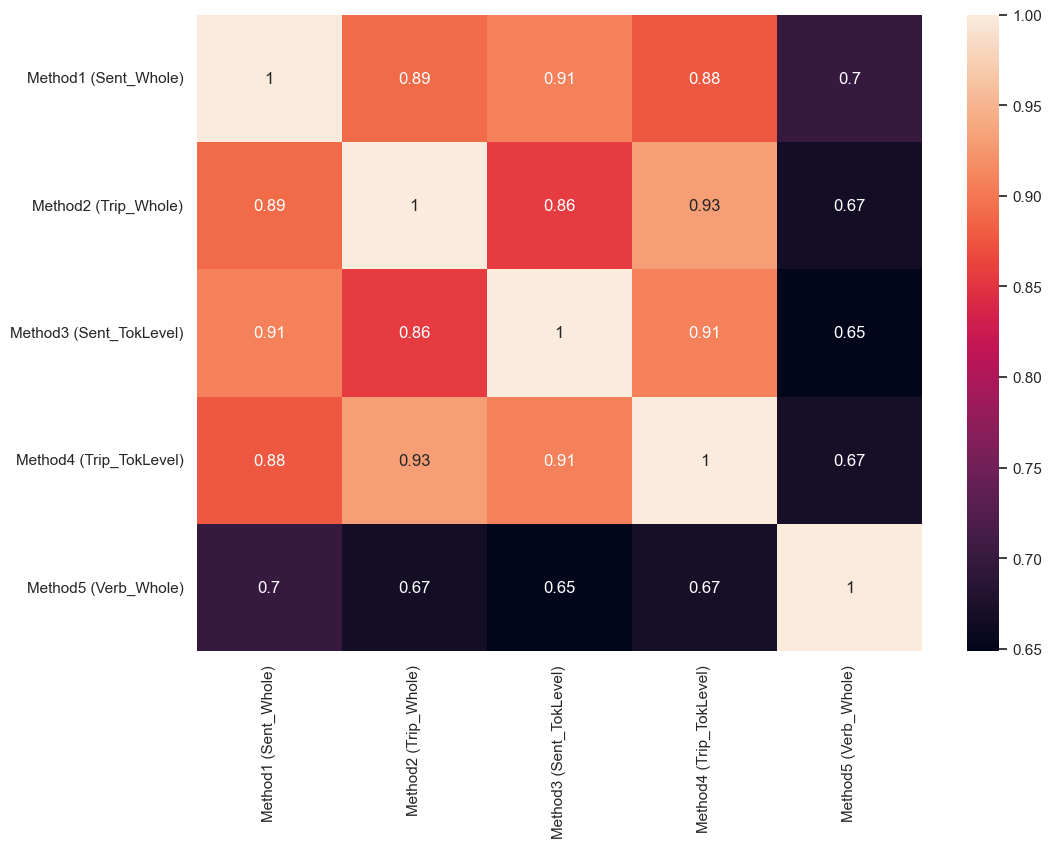

In [38]:
corr_matrix = df_new.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(data=corr_matrix, annot=True)

In [39]:
corr_matrix

,Method1 (Sent_Whole),Method2 (Trip_Whole),Method3 (Sent_TokLevel),Method4 (Trip_TokLevel),Method5 (Verb_Whole)
Method1 (Sent_Whole),1.000000,0.890954,0.907524,0.877176,0.699244
Method2 (Trip_Whole),0.890954,1.000000,0.856213,0.930294,0.665921
Method3 (Sent_TokLevel),0.907524,0.856213,1.000000,0.907191,0.648534
Method4 (Trip_TokLevel),0.877176,0.930294,0.907191,1.000000,0.670433
Method5 (Verb_Whole),0.699244,0.665921,0.648534,0.670433,1.000000
